# Tissue segmentation script using DOSMA
###### Author: Zimu Huo
###### Date: 03.2022

You should have a look at the DOSMA documentation(is an amazing work and well documented), and this script is only a partice example: https://dosma.readthedocs.io/en/latest/documentation.html

If you  want to play with segmentation, download the parameters in the google drive: https://drive.google.com/drive/folders/1qtA70Y56GDzL-BDlVrLhO7EEdvyuHXCw?usp=sharing 

This is provided by dosma, but I want to organise stuff, so here it is.  

In [4]:
import os 
import numpy as np
import dosma as dm
from matplotlib import pyplot as plt
import os
from dosma.models import IWOAIOAIUnet2DNormalized
from skimage.color import label2rgb

In [6]:
def dosma_segmentation(filepath, tissue):
    '''
    -------------------------------------------------------------------------
    Parameters
    
    filepath: string
    filepath for the dicom files to be segemented
    
    tissue: string 
    only four tissues are currently supported by dicom 
     "fc", "pc", "tc", "men"
            1. Femoral cartilage (fc)
            2. Tibial cartilage (tc)
            3. Patellar cartilage (pc)
            4. Meniscus (men)
    
    -------------------------------------------------------------------------
    Returns
    rss : array-like
    combined image
    
    segmentation :  array-like
    mask
    
    -------------------------------------------------------------------------
    Notes: 
    See the DOSMA documentation, this is only a partice example 
    
    -------------------------------------------------------------------------
    References
    
    [1] 
    Author: Desai, Arjun D et al.
    Title: DOSMA: A deep-learning, open-source framework for musculoskeletal MRI analysis.
    Link: https://dosma.readthedocs.io/en/latest/introduction.html
    
    [2] 
    Author: Desai, Arjun D et al.
    Title: The International Workshop on Osteoarthritis Imaging Knee MRI Segmentation Challenge: 
            A Multi-Institute Evaluation and Analysis Framework on a Standardized Dataset
    Link: https://arxiv.org/abs/2004.14003
    '''
    
    
    dr = dm.DicomReader(num_workers=4, verbose=True)
    volumes = dr.load(filepath, group_by="EchoNumbers")
    echo1, echo2 = tuple(volumes)
    echo1, echo2 = echo1.astype(np.float), echo2.astype(np.float)
    rss = np.sqrt(echo1 ** 2 + echo2 **2)
    input_shape = rss.shape[:2] + (1,)
    weights_path = "iwoai-2019-unet2d-normalized_fc-tc-pc-men_weights.h5"
    # trained using DESS data from the Osteoarthritis Initiative (OAI) iMorphics dataset
    model = IWOAIOAIUnet2DNormalized(input_shape, weights_path)
    outputs = model.generate_mask(rss)
    segmentation = outputs[tissue].reformat_as(rss)
    return rss, segmentation

In [7]:
filepath = "knee_data/qdess"
tissue = "fc"  # Possible values: "fc", "pc", "tc", "men"
rss, segmentation = dosma_segmentation(filepath, tissue)

  0%|          | 0/160 [00:00<?, ?it/s]

/var/folders/5d/6p36mvb505x5j7b_90jtxdsr0000gn/T/ipykernel_11598/3568581525.py:48: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  echo1, echo2 = echo1.astype(np.float), echo2.astype(np.float)
2022-05-03 23:20:03.379608: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


5/5 [==============================] - 67s 13s/step


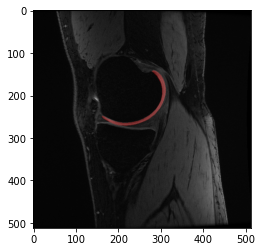

In [8]:
slice_idx = 25  
im_slice = rss.A[..., slice_idx]
im_slice = (im_slice - np.min(im_slice)) / (np.max(im_slice) - np.min(im_slice))
im_slice = np.stack([im_slice] * 3, axis=-1)
im_slice = np.round(im_slice * 255).astype(np.uint8)
labels_slice = segmentation.A[..., slice_idx]
im = label2rgb(labels_slice, image=im_slice, bg_label=0, alpha=0.3)
plt.imshow(im, cmap='gray')